In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sp
import glob
import json
from datetime import datetime
import re

import nltk

from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
from wordcloud import WordCloud

from collections import Counter
from nltk.tokenize import RegexpTokenizer
import re

We are using the Youtube Trending Videos in different countries dataset from kaggle, which has 16 variables including number of views and tags.

We will be focusing on text analysis, and in the end we will solve 2 problems. They are:

1. Category Prediction using text


2. Content Based Recommendation Engine

Let's start by reading in and cleaning our data.

# Reading and cleaning the data

## Reading the data for Germany, Canada, French, United States, and Great Britain

In [2]:
files = [i for i in glob.glob('.\\utubedata\\*.{}'.format('csv'))]

dfs = list()

for csv in files:
    df = pd.read_csv(csv, index_col='video_id')
    df['country'] = csv[12:14]
    dfs.append(df)

my_df = pd.concat(dfs)
my_df.head(3)

,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,country
video_id,,,,,,,,,,,,,,,,
n1WpP7iowLc,17.14.11,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,10,2017-11-10T17:00:03.000Z,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...",17158579,787425,43420,125882,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg,False,False,False,Eminem's new track Walk on Water ft. Beyoncé i...,CA
0dBIkQ4Mz1M,17.14.11,PLUSH - Bad Unboxing Fan Mail,iDubbbzTV,23,2017-11-13T17:00:00.000Z,"plush|""bad unboxing""|""unboxing""|""fan mail""|""id...",1014651,127794,1688,13030,https://i.ytimg.com/vi/0dBIkQ4Mz1M/default.jpg,False,False,False,STill got a lot of packages. Probably will las...,CA
5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146035,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,CA


In [3]:
my_df.shape

(202310, 16)

## Cleaning, reformatting date, time, and inserting categories

In [4]:
mod_df = my_df.copy()
mod_df['trending_date'] = pd.to_datetime(mod_df['trending_date'], errors = 'coerce', format = '%y.%d.%m')
mod_df['publish_time'] = pd.to_datetime(mod_df['publish_time'], errors = 'coerce', format = '%Y-%m-%dT%H:%M:%S.%fZ')
                                             
mod_df = mod_df[mod_df['trending_date'].notnull()]                                           
mod_df = mod_df[mod_df['publish_time'].notnull()]
                                             
mod_df = mod_df.dropna(how = 'any', inplace=  False, axis = 0)

mod_df.insert(4, 'publish_date', mod_df['publish_time'].dt.date)
mod_df['publish_time'] = mod_df['publish_time'].dt.time

mod_df = mod_df.reset_index().drop_duplicates('video_id', keep = 'last').set_index('video_id')

print(mod_df.shape)
mod_df.head()     

(74959, 17)


,trending_date,title,channel_title,category_id,publish_date,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,country
video_id,,,,,,,,,,,,,,,,,
FyZMnhUtLfE,2017-11-14,猎场 | Game Of Hunting 12【TV版】（胡歌、張嘉譯、祖峰等主演）,大劇獨播,1,2017-11-12,16:00:01,"電視劇|""大陸電視劇""|""猎场""|""职场""|""商战""|""爱情""|""都市""|""胡歌""|""陈龙""...",158815,218,30,186,https://i.ytimg.com/vi/FyZMnhUtLfE/default.jpg,False,False,False,Thanks for watching the drama! Help more peopl...,CA
7MxiQ4v0EnE,2017-11-14,Daang ( Full Video ) | Mankirt Aulakh | Sukh S...,Speed Records,10,2017-11-11,16:41:15,"punjabi songs|""punjabi bhangra""|""punjabi music...",5718766,127477,7134,8063,https://i.ytimg.com/vi/7MxiQ4v0EnE/default.jpg,False,False,False,Song - Daang\nSinger - Mankirt Aulakh\nFaceboo...,CA
gifPYwArCVQ,2017-11-14,Fake Pet Smart Employee Prank!,NELK,23,2017-11-13,01:30:01,"prank|""pranks""|""nelk""|""nelkfilmz""|""nelkfilms""",557883,44558,621,9619,https://i.ytimg.com/vi/gifPYwArCVQ/default.jpg,False,False,False,3 Days left to cop NELK merch: https://nelk.ca...,CA
fy-CuCzaPp8,2017-11-14,Rooster Teeth Animated Adventures - Drunk Baby...,Rooster Teeth,1,2017-11-13,14:00:03,"Rooster Teeth|""RT""|""animation""|""television""|""f...",308568,19541,70,495,https://i.ytimg.com/vi/fy-CuCzaPp8/default.jpg,False,False,False,Miles gets stuck at work one night watching ov...,CA
aVTAU_4i9AY,2017-11-14,Throwing Things Into A Fan!,REKT,24,2017-11-12,23:00:00,"Industrial Fan|""Industrial Fan Destruction""|""T...",370827,12150,325,2352,https://i.ytimg.com/vi/aVTAU_4i9AY/default.jpg,False,False,False,Destroying Unbreakable Glasses! ➡ https://www....,CA


In [5]:
mod_df['category_id'] = mod_df['category_id'].astype(str)

category_id = {}

with open('./utubedata/US_category_id.json', 'r') as f:
    data = json.load(f)
    for category in data['items']:
        category_id[category['id']] = category['snippet']['title']

mod_df.insert(4, 'category', mod_df['category_id'].map(category_id))

In [6]:
category_list = mod_df['category'].unique()
category_list

array(['Film & Animation', 'Music', 'Comedy', 'Entertainment',
       'People & Blogs', 'Gaming', 'Sports', 'News & Politics',
       'Travel & Events', 'Autos & Vehicles', 'Howto & Style',
       'Pets & Animals', 'Education', 'Science & Technology', 'Shows',
       'Nonprofits & Activism', 'Trailers', 'Movies'], dtype=object)

Let's see how many videos do we have for each category

In [7]:
for categ in category_list :
    print(categ , mod_df[mod_df['category'] == categ].shape)

Film & Animation (3630, 18)
Music (4923, 18)
Comedy (5274, 18)
Entertainment (23303, 18)
People & Blogs (9597, 18)
Gaming (2782, 18)
Sports (6599, 18)
News & Politics (7616, 18)
Travel & Events (394, 18)
Autos & Vehicles (1461, 18)
Howto & Style (4635, 18)
Pets & Animals (632, 18)
Education (1811, 18)
Science & Technology (1790, 18)
Shows (166, 18)
Nonprofits & Activism (334, 18)
Trailers (2, 18)
Movies (10, 18)


'Trailers' and 'Movies' categories have way few videos, which could lead to misguiding analysis. So let's drop them -- we are dropping only 12 videos (our whole dataset now has 74900+ inputs)

In [8]:
mod_df = mod_df.drop(index = mod_df[mod_df['category'] == 'Movies'].index.tolist())
mod_df = mod_df.drop(index = mod_df[mod_df['category'] == 'Trailers'].index.tolist())

In [9]:
category_list = mod_df['category'].unique()
category_list

array(['Film & Animation', 'Music', 'Comedy', 'Entertainment',
       'People & Blogs', 'Gaming', 'Sports', 'News & Politics',
       'Travel & Events', 'Autos & Vehicles', 'Howto & Style',
       'Pets & Animals', 'Education', 'Science & Technology', 'Shows',
       'Nonprofits & Activism'], dtype=object)

In [10]:
for categ in category_list :
    print(categ , mod_df[mod_df['category'] == categ].shape)

Film & Animation (3630, 18)
Music (4923, 18)
Comedy (5274, 18)
Entertainment (23303, 18)
People & Blogs (9597, 18)
Gaming (2782, 18)
Sports (6599, 18)
News & Politics (7616, 18)
Travel & Events (394, 18)
Autos & Vehicles (1461, 18)
Howto & Style (4635, 18)
Pets & Animals (632, 18)
Education (1811, 18)
Science & Technology (1790, 18)
Shows (166, 18)
Nonprofits & Activism (334, 18)


Now, let's clean the description and tags by excluding stopwords (common words) digits, single letter words, and symbols.

In [11]:
en_stopwords = list(stopwords.words('english'))
de_stopwords = list(stopwords.words('german'))   
fr_stopwords = list(stopwords.words('french'))   
en_stopwords.extend(de_stopwords)
en_stopwords.extend(fr_stopwords)

def clean_text(x) :
    text = x.lower()
    
    text = re.sub('[^A-Za-z]+', ' ', text)
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w in en_stopwords]
    without_single_chr = [word for word in filtered_sentence if len(word) > 2]
    cleaned_data_title = [word for word in without_single_chr if not word.isdigit()]
    
    return ' '.join(cleaned_data_title)

In [12]:
clean_desc = mod_df['description'].apply(lambda x: clean_text(x))
mod_df = pd.concat([mod_df, clean_desc.rename("clean_description")], axis = 1)

clean_tags = mod_df['tags'].apply(lambda x: clean_text(x))
mod_df = pd.concat([mod_df, clean_tags.rename("clean_tags")], axis = 1)

Now our cleaned data is:

In [13]:
mod_df

,trending_date,title,channel_title,category_id,category,publish_date,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,country,clean_description,clean_tags
video_id,,,,,,,,,,,,,,,,,,,,
FyZMnhUtLfE,2017-11-14,猎场 | Game Of Hunting 12【TV版】（胡歌、張嘉譯、祖峰等主演）,大劇獨播,1,Film & Animation,2017-11-12,16:00:01,"電視劇|""大陸電視劇""|""猎场""|""职场""|""商战""|""爱情""|""都市""|""胡歌""|""陈龙""...",158815,218,30,186,https://i.ytimg.com/vi/FyZMnhUtLfE/default.jpg,False,False,False,Thanks for watching the drama! Help more peopl...,CA,thanks watching drama help people watch game h...,huge chenlong sunhonglei zhangjiayi zufeng liq...
7MxiQ4v0EnE,2017-11-14,Daang ( Full Video ) | Mankirt Aulakh | Sukh S...,Speed Records,10,Music,2017-11-11,16:41:15,"punjabi songs|""punjabi bhangra""|""punjabi music...",5718766,127477,7134,8063,https://i.ytimg.com/vi/7MxiQ4v0EnE/default.jpg,False,False,False,Song - Daang\nSinger - Mankirt Aulakh\nFaceboo...,CA,song daang nsinger mankirt aulakh nfacebook ht...,punjabi songs punjabi bhangra punjabi music pu...
gifPYwArCVQ,2017-11-14,Fake Pet Smart Employee Prank!,NELK,23,Comedy,2017-11-13,01:30:01,"prank|""pranks""|""nelk""|""nelkfilmz""|""nelkfilms""",557883,44558,621,9619,https://i.ytimg.com/vi/gifPYwArCVQ/default.jpg,False,False,False,3 Days left to cop NELK merch: https://nelk.ca...,CA,days left cop nelk merch https nelk nfollow in...,prank pranks nelk nelkfilmz nelkfilms
fy-CuCzaPp8,2017-11-14,Rooster Teeth Animated Adventures - Drunk Baby...,Rooster Teeth,1,Film & Animation,2017-11-13,14:00:03,"Rooster Teeth|""RT""|""animation""|""television""|""f...",308568,19541,70,495,https://i.ytimg.com/vi/fy-CuCzaPp8/default.jpg,False,False,False,Miles gets stuck at work one night watching ov...,CA,miles gets stuck work one night watching drunk...,rooster teeth animation television filmmaking ...
aVTAU_4i9AY,2017-11-14,Throwing Things Into A Fan!,REKT,24,Entertainment,2017-11-12,23:00:00,"Industrial Fan|""Industrial Fan Destruction""|""T...",370827,12150,325,2352,https://i.ytimg.com/vi/aVTAU_4i9AY/default.jpg,False,False,False,Destroying Unbreakable Glasses! ➡ https://www....,CA,destroying unbreakable glasses https www youtu...,industrial fan industrial fan destruction thro...
m-nZmgHWoEw,2017-11-14,Mythical Dog Party,Good Mythical MORE,24,Entertainment,2017-11-13,11:00:06,"rhett and link|""good mythical more""|""rhett and...",116676,4324,136,618,https://i.ytimg.com/vi/m-nZmgHWoEw/default.jpg,False,False,False,We're hanging with some of the dogs of the Myt...,CA,hanging dogs mythical crew forcing lyrical los...,rhett link good mythical rhett link good mythi...
_A5Z00E5gx8,2017-11-14,急诊科医生 | Emergency Physician 25（张嘉译、王珞丹、柯蓝等主演）,麻辣变形计 HOT GIRL,22,People & Blogs,2017-11-12,16:00:02,"马克|""迪丽热巴""|""麻辣变形计""|""军旅""|""美女""|""感情""|""都市""|""电视剧""|""热...",123778,82,20,64,https://i.ytimg.com/vi/_A5Z00E5gx8/default.jpg,False,False,False,【欢迎订阅本频道】\n\n该剧讲述了急诊科主任医生何建一与海归医生江晓琪从一开始的互相审视，...,CA,,zhangjiayi wangluodan jiangshan kelan kongzheng
uEu5--lyNCE,2017-11-14,Cats Hate Pregnant - Off Topic #102,Achievement Hunter,20,Gaming,2017-11-12,18:00:03,"Achievement Hunter|""AH""|""video game""|""gaming""|...",191353,3307,85,534,https://i.ytimg.com/vi/uEu5--lyNCE/default.jpg,False,False,False,The AH Crew sit down to talk about Jeremy’s ba...,CA,crew sit talk jeremy bad morning baby sounds e...,achievement hunter video game gaming game game...
FSdg3UVuBKE,2017-11-14,Autumn's sick...,Sugar Pine 7,24,Entertainment,2017-11-13,03:08:01,"sugar pine 7|""steven suptic""|""autumn""|""sick""|""...",182330,14901,55,1442,https://i.ytimg.com/vi/FSdg3UVuBKE/default.jpg,False,False,False,She needs your prayers.\nNEW MERCH!\nhttps://s...,CA,needs prayers nnew merch nhttps store roostert...,sugar pine steven suptic autumn sick parker va...


# Numerical Analysis

## Univariate analysis

In [14]:
mod_df.describe()

,views,likes,dislikes,comment_count
count,7.494700e+04,7.494700e+04,7.494700e+04,7.494700e+04
mean,5.185779e+05,1.426788e+04,7.704594e+02,1.740344e+03
std,3.921224e+06,7.330830e+04,8.230495e+03,1.023608e+04
min,2.840000e+02,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.267500e+04,4.260000e+02,2.200000e+01,6.900000e+01
50%,9.891600e+04,2.143000e+03,9.400000e+01,3.150000e+02
75%,3.395570e+05,8.386500e+03,3.430000e+02,1.109000e+03
max,4.245389e+08,5.613827e+06,1.643059e+06,1.228655e+06


The max value is so much higher than the third quartile. It will cause our plot to be harder to see, so let's drop some outliers before plotting it.

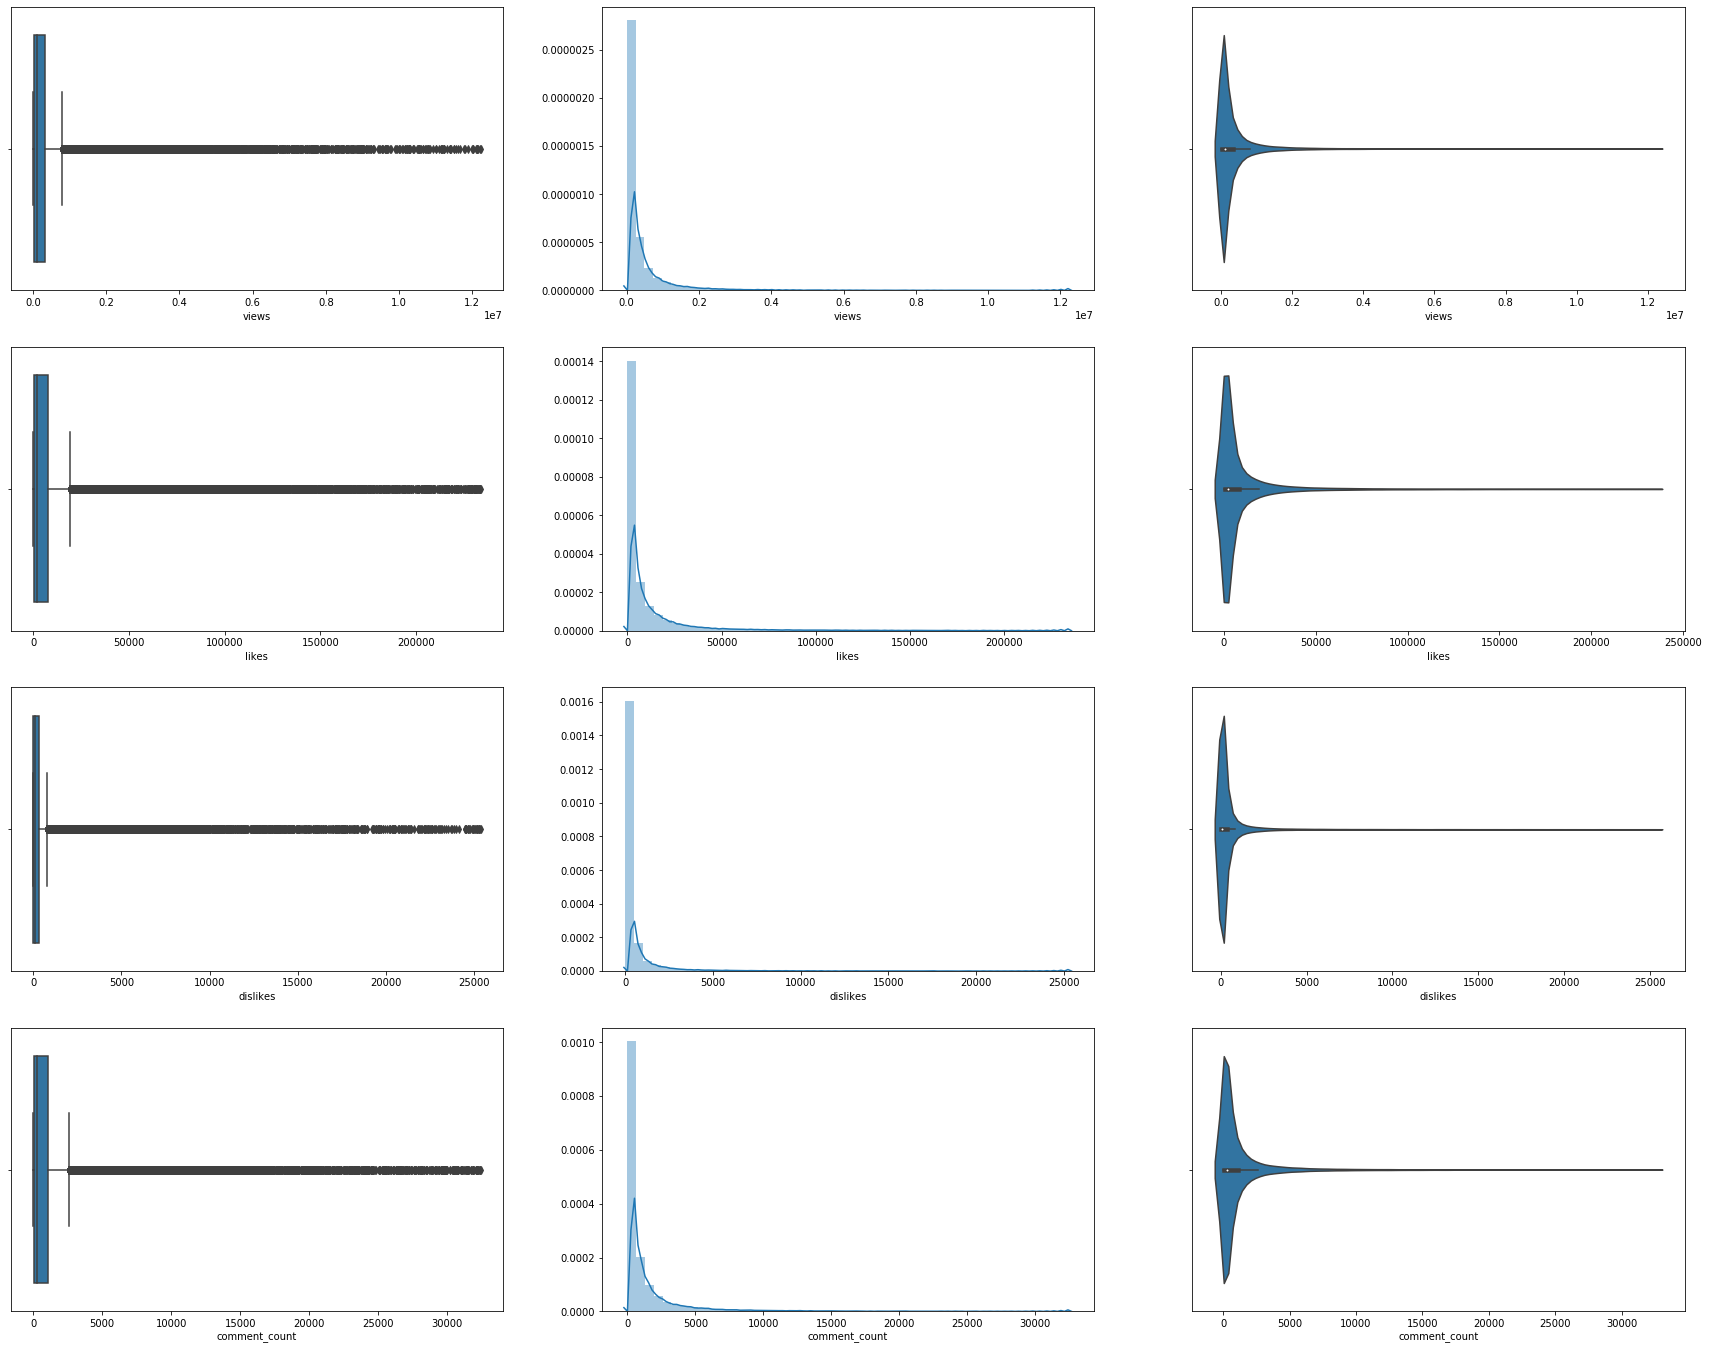

In [15]:
f, ax = plt.subplots(4, 3, figsize = (30, 24))
count = 0
for var in ['views', 'likes', 'dislikes', 'comment_count'] :
    upper_boundary = mod_df[var].mean() + 3 * mod_df[var].std() 
    uni = mod_df[mod_df[var] < upper_boundary][var]
    sns.boxplot(uni, ax = ax[count, 0])
    sns.distplot(uni, ax = ax[count, 1])
    sns.violinplot(uni, ax = ax[count, 2])
    count = count + 1

The the distribution is hugely focused on smaller values since getting a huge number of views, likes, or comments is very rare.

### Analysis on published date and time

Number of trending videos published on each day

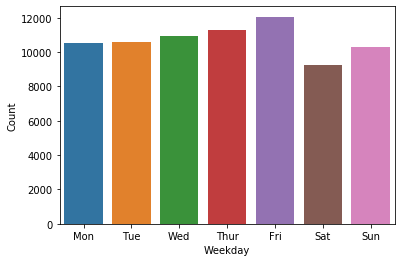

In [16]:
weekdays_list = ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']
def weekday(date) :
    return weekdays_list[date.weekday()]

publish_weekday = mod_df['publish_date'].apply(lambda x: weekday(x))
publish_weekday_count = pd.DataFrame(data = {}, columns = ['Weekday', 'Count'])

for day in weekdays_list :
    count = publish_weekday[publish_weekday == day].count()
    #print(count)
    temp = pd.DataFrame({'Weekday' : [day], 'Count' : [count]})
    #print(temp)
    publish_weekday_count = publish_weekday_count.append(temp) 
sns.barplot(x = publish_weekday_count['Weekday'], y = publish_weekday_count['Count'])

If we sort it :

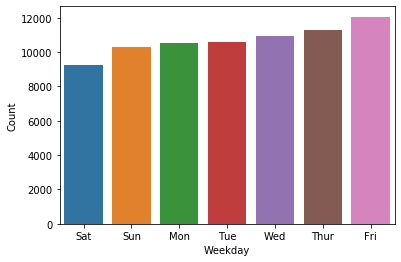

In [17]:
publish_weekday_count = publish_weekday_count.sort_values('Count')
sns.barplot(x = publish_weekday_count['Weekday'], y = publish_weekday_count['Count'])

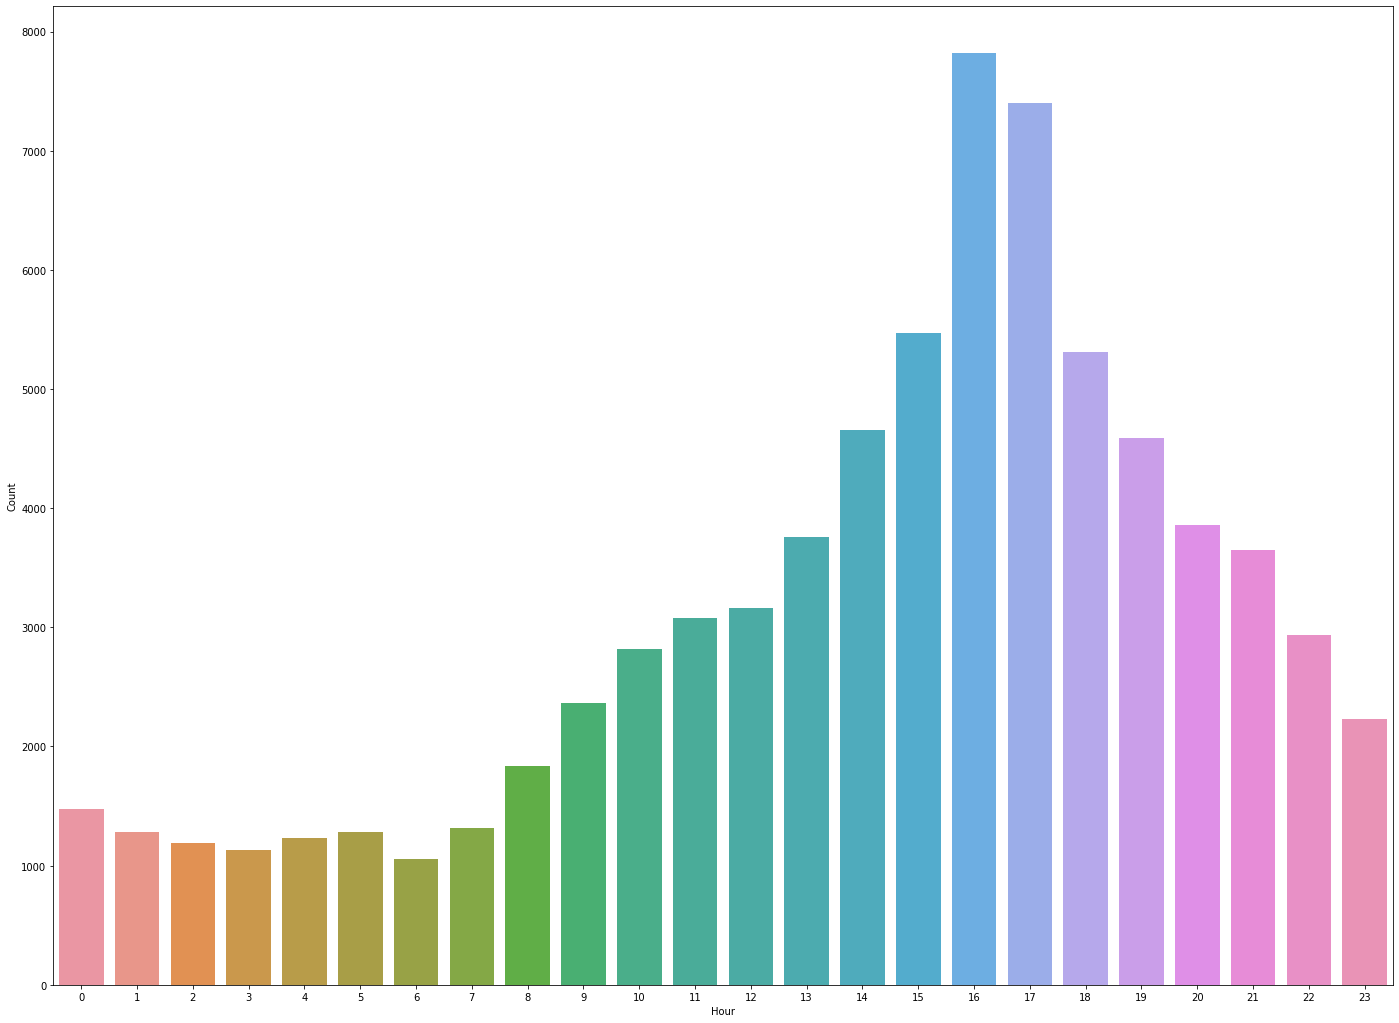

In [18]:
f, axes = plt.subplots(figsize = (24, 18))

def time(x) :
    hour = x.hour
    if (x.minute > 30) :
        hour = hour + 1
    if (hour == 24) :
        hour = 0
    return hour

publish_hour = mod_df['publish_time'].apply(lambda x: time(x))
publish_hour_count = pd.DataFrame(data = {}, columns = ['Hour', 'Count'])

for hour in range(0, 24) :
    count = publish_hour[publish_hour == hour].count()
    temp = pd.DataFrame({'Hour' : [hour], 'Count' : [count]})
    publish_hour_count = publish_hour_count.append(temp)
sns.barplot(x = publish_hour_count['Hour'], y = publish_hour_count['Count'], ax = axes)

Most of the videos are posted between 14:00 and 19:00, while the posted weekday does not have that big effect, apparently. We can observe a slight monotonic increase from Saturday to Friday sequentially.

### Category-wise distribution

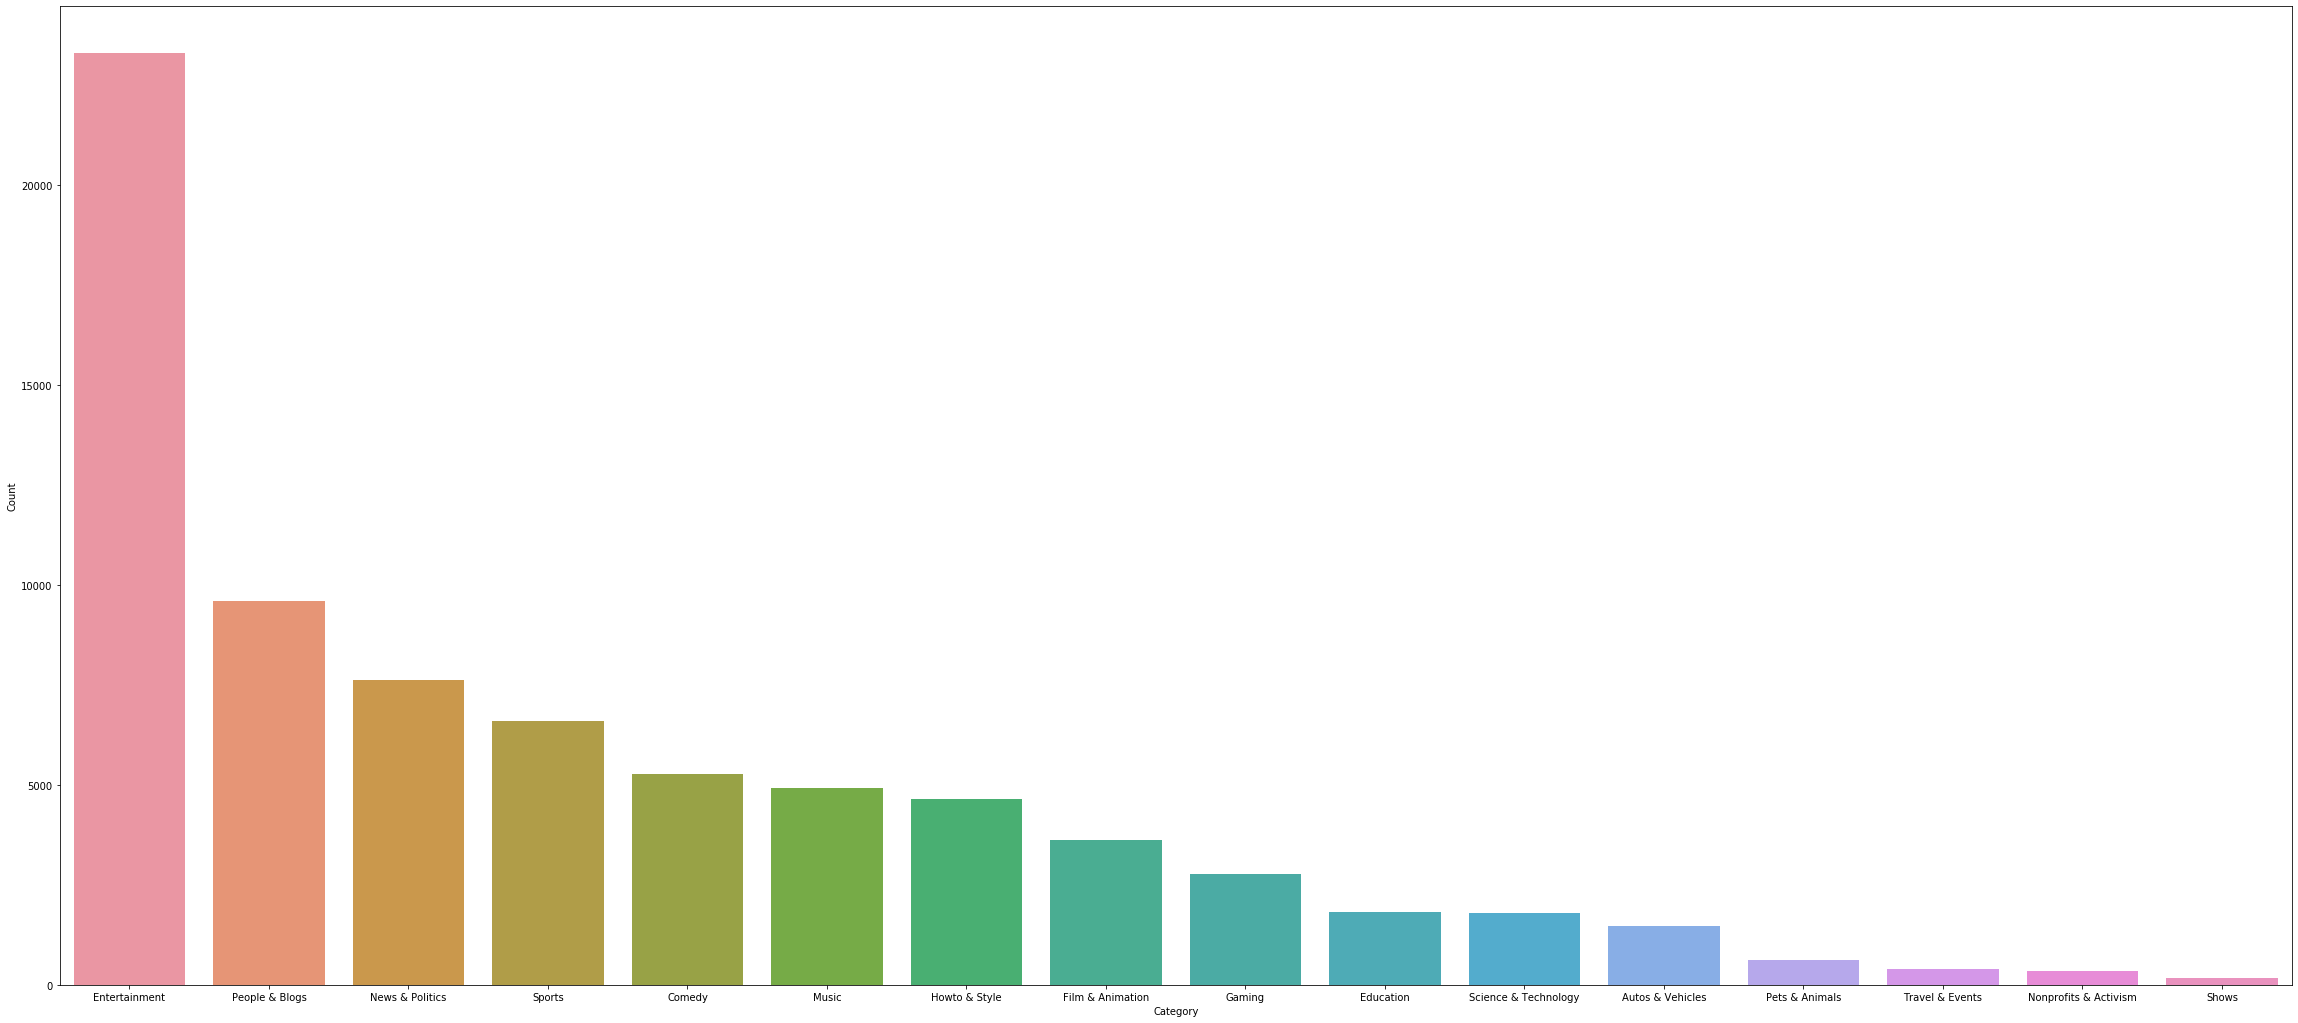

In [19]:
f, axes = plt.subplots(figsize = (40, 18))

def time(x) :
    hour = x.hour
    if (x.minute > 30) :
        hour = hour + 1
    if (hour == 24) :
        hour = 0
    return hour

category_series = mod_df['category']
category_count = pd.DataFrame(data = {}, columns = ['Category', 'Count'])

for var in category_list :
    count = category_series[category_series == var].count()
    temp = pd.DataFrame({'Category' : [var], 'Count' : [count]})
    category_count = category_count.append(temp)
    category_count = category_count.sort_values(by = ['Count'], ascending = False)
sns.barplot(x = category_count['Category'], y = category_count['Count'], ax = axes, orient = "v")

### Distribution of title lengths of the videos:

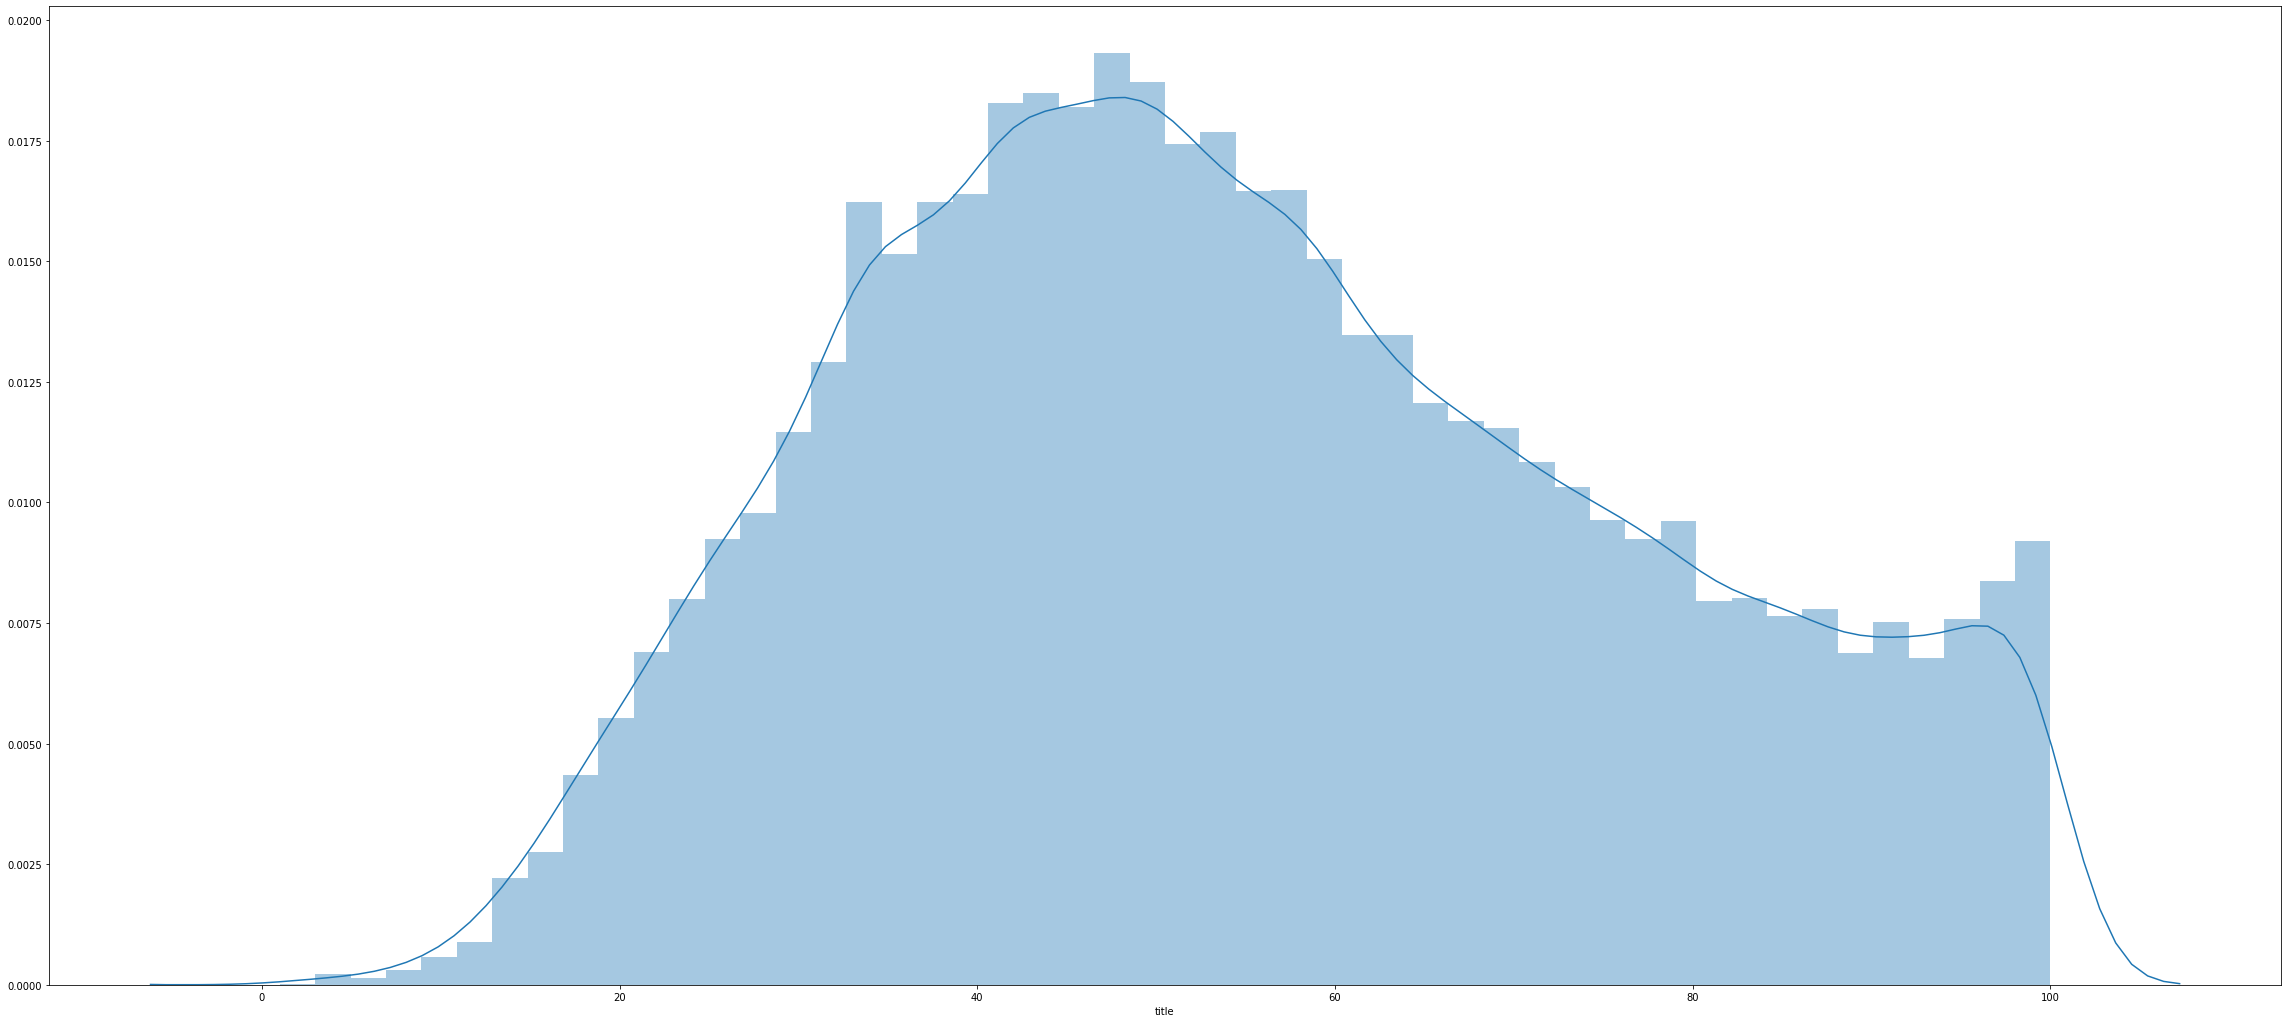

In [20]:
f, axes = plt.subplots(figsize = (40, 18))

def time(x) :
    hour = x.hour
    if (x.minute > 30) :
        hour = hour + 1
    if (hour == 24) :
        hour = 0
    return hour

title_length = mod_df['title'].apply(lambda x : len(x))
sns.distplot(title_length, ax = axes)

The distribution is similar to Normal distribution, except the total lenght of a title is probably capped between 0 and 100 since there is no value outside this range. 

## Bivariate analysis

### Analysis on 'views', 'likes', 'dislikes', and 'comment_count'

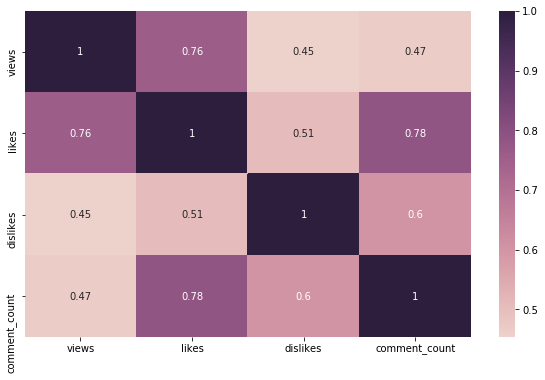

In [21]:
num = mod_df[['views', 'likes', 'dislikes', 'comment_count']]
fig, ax = plt.subplots(figsize=(10,6))
_ = sns.heatmap(num.corr(), annot=True, cmap=sns.cubehelix_palette(as_cmap=True), ax=ax)

We can observe a high correlation between 'likes' and 'views', as well as between 'likes' and 'comment_count'. If we plot each pair:

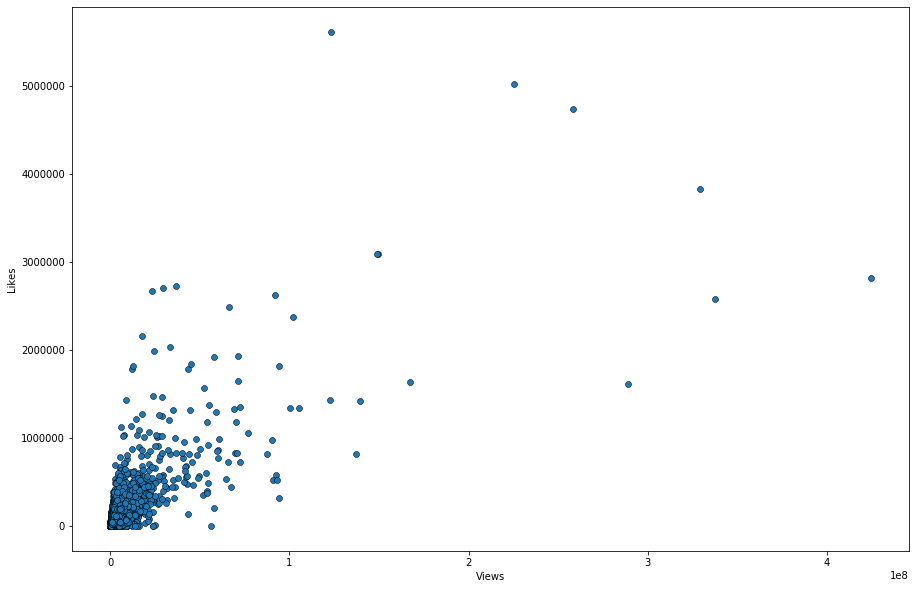

In [22]:
fig, ax = plt.subplots(figsize = (15, 10))
_ = plt.scatter(x=mod_df['views'], y=mod_df['likes'], edgecolors="#000000", linewidths=0.5)
_ = ax.set(xlabel="Views", ylabel="Likes")

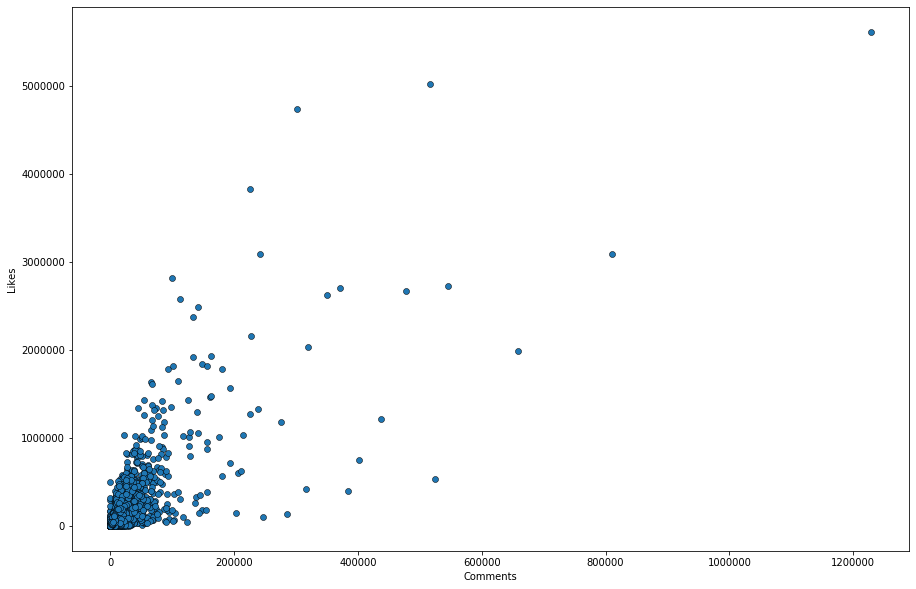

In [23]:
fig, ax = plt.subplots(figsize = (15, 10))
_ = plt.scatter(x=mod_df['comment_count'], y=mod_df['likes'], edgecolors="#000000", linewidths=0.5)
_ = ax.set(xlabel="Comments", ylabel="Likes")

We will be mainly focusing the text portion as our main problem, so let's
move on to the text analysis.

# Text Analysis

In [24]:
def wcloud(data, title, bgcolor):
    plt.figure(figsize = (20,15))
    cloud = WordCloud(background_color = bgcolor, max_words = 100,  max_font_size = 50)
    cloud.generate(' '.join(data))
    plt.imshow(cloud)
    plt.axis('off')
    plt.title(title)

## Analyzing videos according to their descriptions.

In [25]:
mod_df[mod_df['category']=="Entertainment"]['clean_description'].head(3)

video_id
aVTAU_4i9AY    destroying unbreakable glasses https www youtu...
m-nZmgHWoEw    hanging dogs mythical crew forcing lyrical los...
FSdg3UVuBKE    needs prayers nnew merch nhttps store roostert...
Name: clean_description, dtype: object

Let's see the polarity of the most frequently mentioned words for each category.

Film & Animation 9.318699999999998
Music 15.398200000000005
Comedy 15.876299999999997
Entertainment 16.858400000000003
People & Blogs 14.225999999999999
Gaming 14.0539
Sports 12.232299999999999
News & Politics 17.091900000000006
Travel & Events 25.4521
Autos & Vehicles 6.5537
Howto & Style 18.4257
Pets & Animals 24.334600000000005
Education 12.703300000000004
Science & Technology 6.770400000000002
Shows 5.638800000000001
Nonprofits & Activism 12.312100000000004


Text(0.5, 1.0, 'Polarity of Categories in Youtube videos')

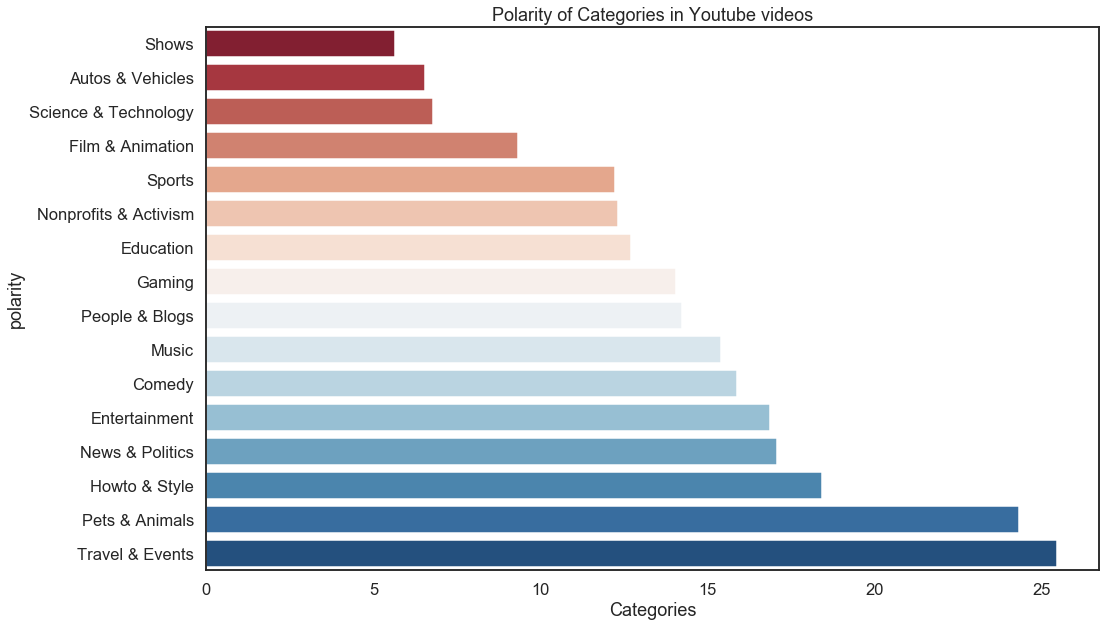

In [26]:
MAX_N = 1000
category_list = mod_df['category'].unique()

polarities = list()

for category in category_list:
    categ_word_list = mod_df[mod_df['category']==category]['clean_description'].str.cat(sep=' ')
    word_tokens = word_tokenize(categ_word_list)
    
# Calculate frequency distribution
    word_dist = nltk.FreqDist(word_tokens)
    hnhk = pd.DataFrame(word_dist.most_common(MAX_N),
                    columns=['Word', 'Frequency'])

    compound = .0
    for word in hnhk['Word'].head(MAX_N):
        compound += SentimentIntensityAnalyzer().polarity_scores(word)['compound']
    polarities.append(compound)
    print(category, compound)
    
category_list_df = pd.DataFrame(category_list)
polarities_df = pd.DataFrame(polarities)
tags_sentiment = pd.concat([category_list_df,polarities_df],axis=1)
tags_sentiment.columns = ['category','polarity']
tags_sentiment=tags_sentiment.sort_values('polarity').reset_index()
plt.figure(figsize=(16,10))
sns.set(style="white",context="talk")
ax = sns.barplot(x=tags_sentiment['polarity'],y=tags_sentiment['category'], data=tags_sentiment,orient='h',palette="RdBu")
plt.xlabel("Categories")
plt.ylabel("polarity")
plt.title("Polarity of Categories in Youtube videos")

From this graph, we hypothesize that people rarely include negative words in their description. Let's see what are the most frequently mentioned words for each category.

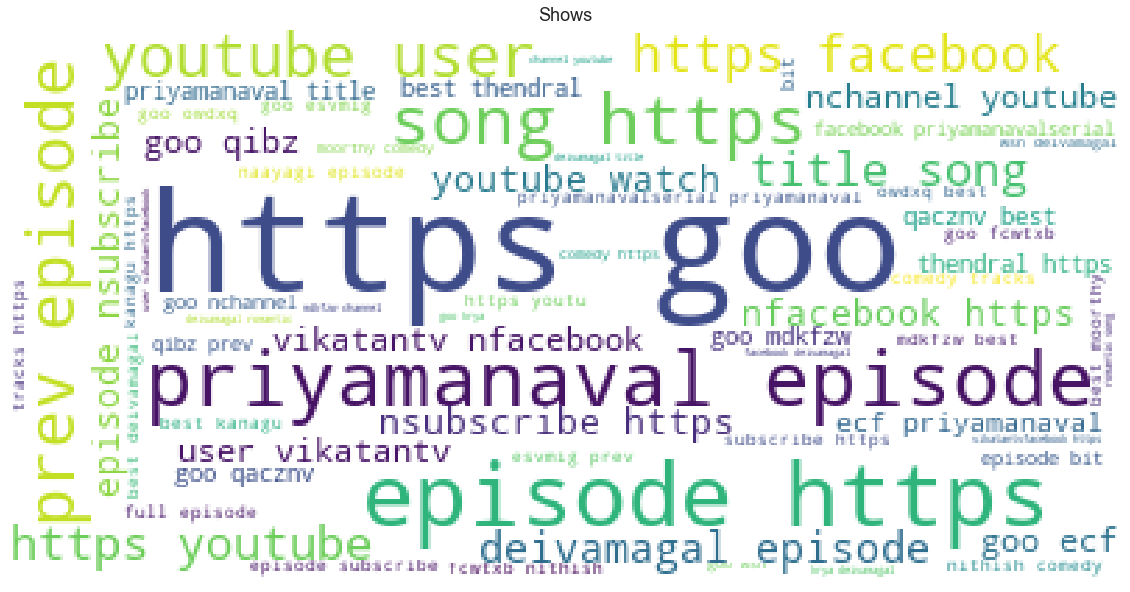

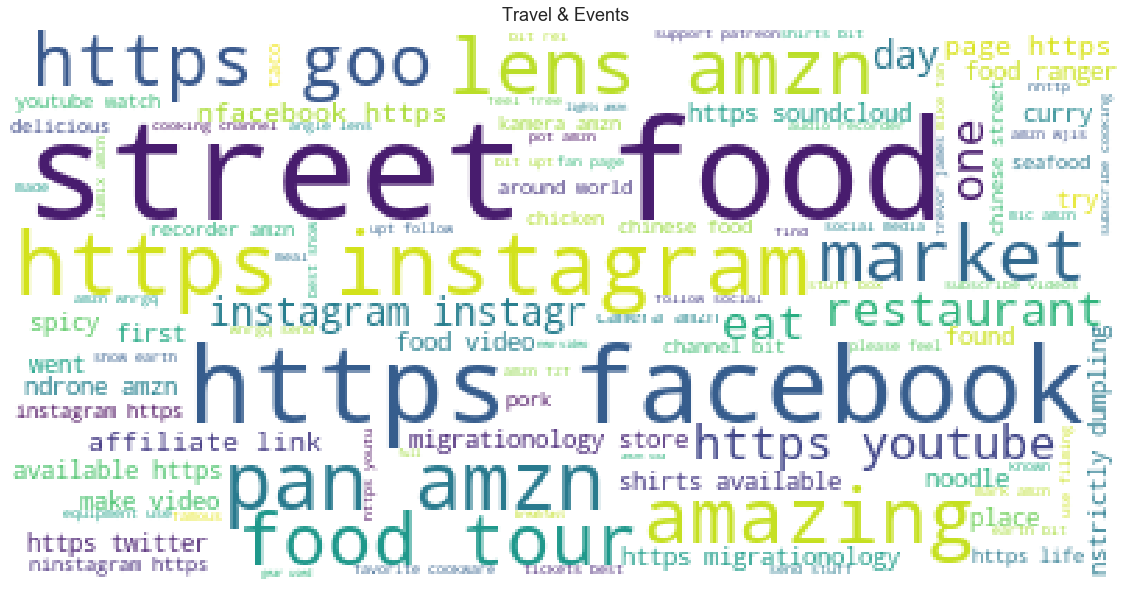

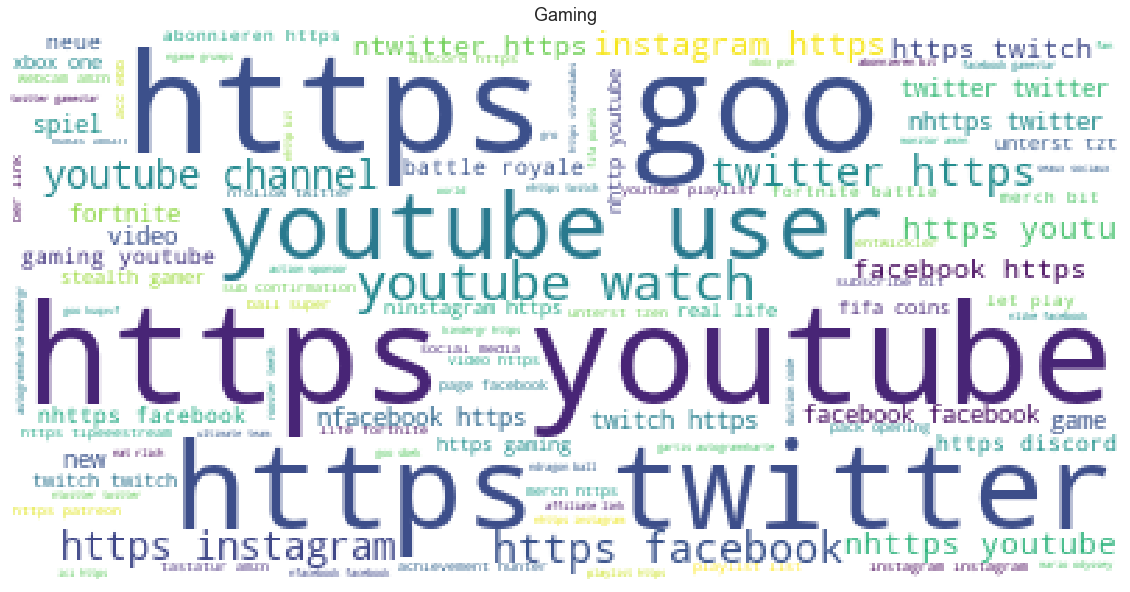

In [27]:
some_category = ["Shows", "Travel & Events", "Gaming"]

for category in some_category :
    categ_word_list = mod_df[mod_df['category']==category]['clean_description'].str.cat(sep=' ')
    word_tokens = word_tokenize(categ_word_list)
    
    wcloud(word_tokens, category, 'white')

However, description mostly include links to other social media platforms, and it is not so appropriate to conclude something from the sentiment analysis of descriptions. Instead, let's use 'tags' which should be more specific in terms of expressing the video.

## Analyzing videos according to their tags

Let's see the polarity of the most common tags for each category.

Film & Animation 4.512499999999999
Music 12.581900000000006
Comedy 10.5827
Entertainment 8.788199999999998
People & Blogs 15.509199999999998
Gaming 8.755399999999998
Sports 8.067099999999996
News & Politics -2.5281000000000002
Travel & Events 10.766600000000004
Autos & Vehicles 0.011500000000000177
Howto & Style 13.886699999999996
Pets & Animals 8.565200000000003
Education 2.4426999999999994
Science & Technology 4.513100000000001
Shows 1.4372000000000007
Nonprofits & Activism -1.3507999999999996


Text(0.5, 1.0, 'Polarity of Categories in Youtube videos')

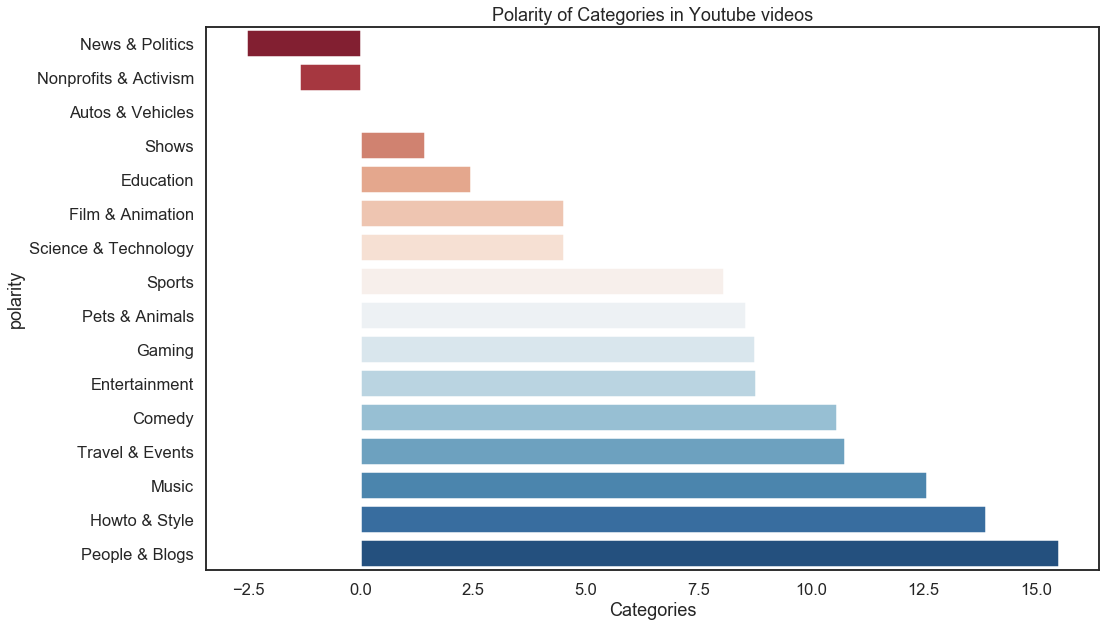

In [28]:
MAX_N = 1000
category_list = mod_df['category'].unique()

#remove all the stopwords from the text
polarities = list()

for category in category_list:
    categ_word_list = mod_df[mod_df['category']==category]['clean_tags'].str.cat(sep=' ')
    word_tokens = word_tokenize(categ_word_list)

# Calculate frequency distribution
    word_dist = nltk.FreqDist(word_tokens)
    hnhk = pd.DataFrame(word_dist.most_common(MAX_N),
                    columns=['Word', 'Frequency'])

    compound = .0
    for word in hnhk['Word'].head(MAX_N):
        compound += SentimentIntensityAnalyzer().polarity_scores(word)['compound']

    polarities.append(compound)
    print(category, compound)
    
category_list_df = pd.DataFrame(category_list)
polarities_df = pd.DataFrame(polarities)
tags_sentiment = pd.concat([category_list_df,polarities_df],axis=1)
tags_sentiment.columns = ['category','polarity']
tags_sentiment=tags_sentiment.sort_values('polarity').reset_index()
plt.figure(figsize=(16,10))
sns.set(style="white",context="talk")
ax = sns.barplot(x=tags_sentiment['polarity'],y=tags_sentiment['category'], data=tags_sentiment,orient='h',palette="RdBu")
plt.xlabel("Categories")
plt.ylabel("polarity")
plt.title("Polarity of Categories in Youtube videos")

Surprisingly, 'News & Politics' has the most negative tags, while 'People & Blogs' has the most positive tags. Another interesting category is 'Autos & Vehicles' as its polarity is almost 0.

Let's see what are the most repeated tags in these 3 categories.

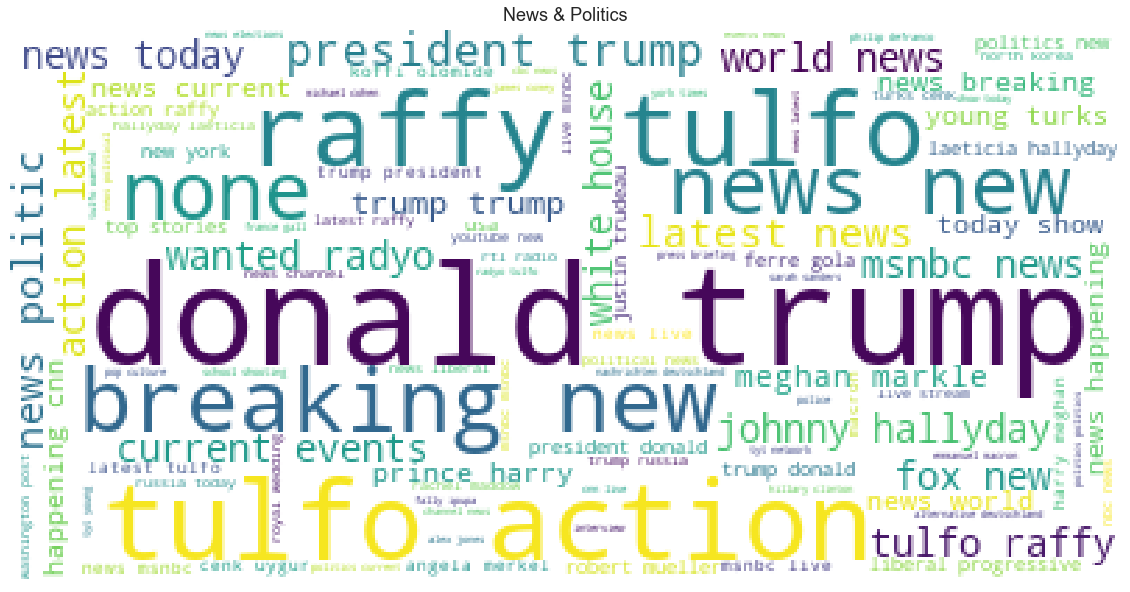

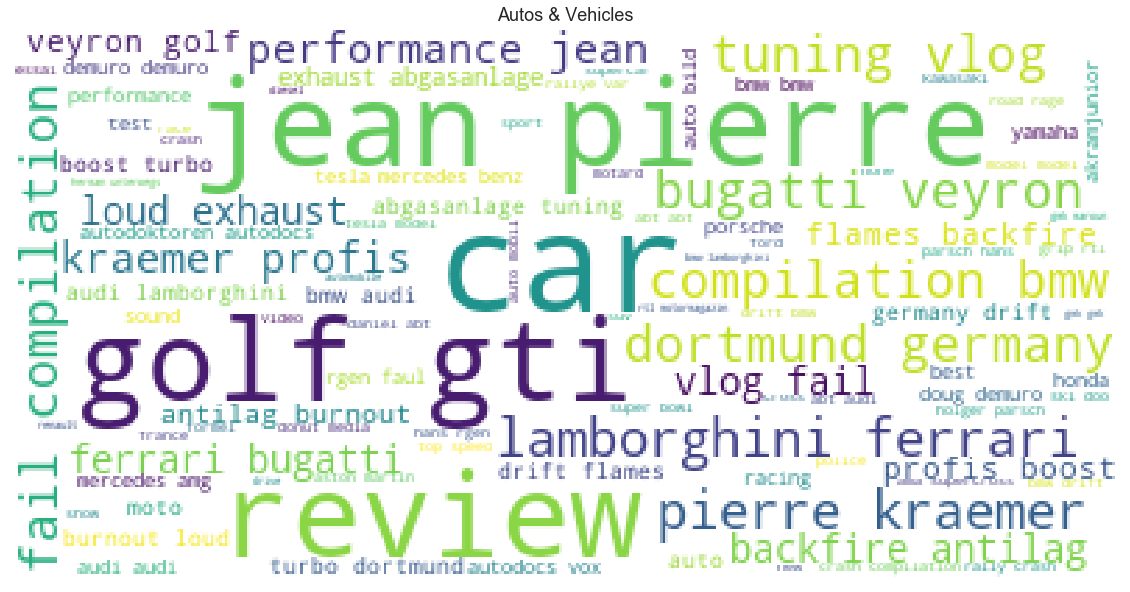

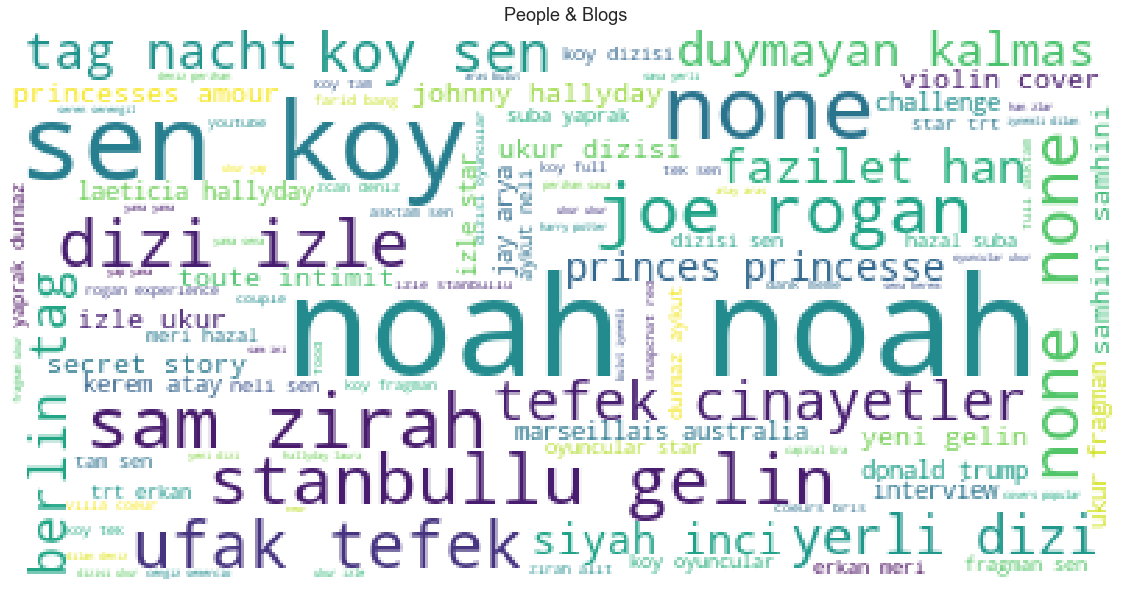

In [29]:
some_categories = ['News & Politics', 'Autos & Vehicles', 'People & Blogs']
for category in some_categories :
    categ_word_list = mod_df[mod_df['category']==category]['clean_tags'].str.cat(sep=' ')
    word_tokens = word_tokenize(categ_word_list)
    wcloud(word_tokens, category, 'white')

As expected, 'tags' is a better factor for analyzing videos. And seems like Donald Trump and Noah are quite famous.

# Problem 1: Category prediction using 'tags'

Now, let's try to predict the categories of videos using 'tags' as the variable. We will be using Gaussian Naive Bayes method for our classification.

In [30]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

Let's cut down our dataset to only trending videos in US because the whole dataset is too big for our devices.

In [31]:
us_data = mod_df[mod_df["country"] == "US"]
print(us_data.shape)
us_data.head(3)

(6254, 20)


,trending_date,title,channel_title,category_id,category,publish_date,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,country,clean_description,clean_tags
video_id,,,,,,,,,,,,,,,,,,,,
9wRQljFNDW8,2017-11-14,Dion Lewis' 103-Yd Kick Return TD vs. Denver! ...,NFL,17,Sports,2017-11-13,02:05:26,"NFL|""Football""|""offense""|""defense""|""afc""|""nfc""...",81377,655,25,177,https://i.ytimg.com/vi/9wRQljFNDW8/default.jpg,False,False,False,New England Patriots returner Dion Lewis blast...,US,new england patriots returner dion lewis blast...,nfl football offense defense afc nfc american ...
Om_zGhJLZ5U,2017-11-14,TL;DW - Every DCEU Movie Before Justice League,Screen Junkies,1,Film & Animation,2017-11-12,18:00:03,"screenjunkies|""screen junkies""|""sj news""|""hone...",288922,7515,792,2111,https://i.ytimg.com/vi/Om_zGhJLZ5U/default.jpg,False,False,False,With Justice League approaching fast we rewatc...,US,justice league approaching fast rewatched four...,screenjunkies screen junkies news honest trail...
goP4Z5wyOlM,2017-11-14,Iraq-Iran earthquake: Deadly tremor hits borde...,BBC News,25,News & Politics,2017-11-12,21:16:40,"bbc|""bbc news""|""news""|""iran""|""iran news""|""iraq...",34785,308,26,413,https://i.ytimg.com/vi/goP4Z5wyOlM/default.jpg,False,False,False,A strong 7.2-magnitude earthquake has rattled ...,US,strong magnitude earthquake rattled northern i...,bbc bbc news news iran iran news iraq iraq new...


We can not use raw "tags" as the predictor because the "tag" array would not have the uniform length. So we are vectorizing it and using results as our predictor. 
Train Data : 80%
Test Data : 20%

In [32]:
us_clean_tags = us_data['clean_tags']
us_count_vector = CountVectorizer()
us_count_vector_matrix = us_count_vector.fit_transform(us_clean_tags)

predictor = us_count_vector_matrix.toarray()
target = us_data["category"].to_numpy()

x_train, x_test, y_train, y_test = train_test_split(predictor, target, test_size = 0.20)

model_gnb = GaussianNB()
model_gnb.fit(x_train, y_train)

print("Score on train dataset: ", model_gnb.score(x_train, y_train))
print("Score on test dataset:", model_gnb.score(x_test, y_test))
print("Score on the full dataset:", model_gnb.score(predictor, target))

Score on train dataset:  0.9436338197081751
Score on test dataset: 0.5875299760191847
Score on the full dataset: 0.8724016629357212


The accuracy is not too bad on our train dataset, but it is almost 60% on our test dataset. We assume that it is due to the trending video tags are changing continuously, making it harder to make predictions on new inputs.

## Problem 2: Content-Based Recommendation Engine

As we have seen before, 'tags' gives much more information to us compared to 'description'. So we will try to make a recommendation engine with the tags of videos.

In [33]:
from sklearn.metrics.pairwise import cosine_similarity

Again, we are vectorizing tag strings using CountVectorizer from sklearn, and then finding similar videos using cosine_similarity between tags. 

In [34]:
clean_tags = mod_df["clean_tags"]
count_vector = CountVectorizer()
count_vector_matrix = count_vector.fit_transform(clean_tags)
indices = pd.Series(clean_tags.index)

def recommend_by_id(id) :
    
    recommended_list = []
    
    idx = indices[indices == id].index[0]
    
    cosine_sim = cosine_similarity(count_vector_matrix[idx], count_vector_matrix)
    score_series = pd.Series(cosine_sim[0]).sort_values(ascending = False)
    
    top_10_indexes = list(score_series.iloc[1:11].index)
    print(top_10_indexes)
    for i in top_10_indexes:
        recommended_list.append(list(clean_tags.index)[i])

    #create a dataframe of title and thumbnail_link pairs for recommended videos
    recommendation_df = pd.DataFrame({'Title' : [], 'Thumbnail_link' : []})

    for id in recommended_list :
        title = mod_df['title'][id]
        link = mod_df['thumbnail_link'][id]

        df = pd.DataFrame({'Title' : [title], 'Thumbnail_link' : [link]})
        recommendation_df = recommendation_df.append(df)
        
    print("Recommended videos for: ", mod_df['title'][id])
    print(recommendation_df['Title'])
    
    return recommendation_df

Displaying thumbnails of recommended videos:

In [35]:
from IPython.display import HTML, display

In [36]:
def display_thumbnail(df) :
    ROW = 5
    COLUMN = 2
    tempHTML = ''
    innerHTML = '<div style="block">'
    
    link_df = df['Thumbnail_link'].reset_index()['Thumbnail_link']
    for r in range(ROW):
        rowHTML = ''
        for c in range(COLUMN):
            tempHTML = '<img src="' + link_df[c*3+r] + '"style="float:left;width:200px;height:200px;margin:0">'
            rowHTML += tempHTML
        innerHTML += rowHTML
    innerHTML += '</div>'
    display(HTML(innerHTML))

In [37]:
display_thumbnail(recommend_by_id('n1WpP7iowLc'))

[70720, 67208, 39280, 69194, 67997, 6480, 68328, 70098, 44057, 43639]
Recommended videos for:  Eminem - River (Audio) ft. Ed Sheeran
0    Eminem - Walk On Water (Official Video) ft. Be...
0                Walk On Water (Official Video Teaser)
0    Eminem Performs 'Walk On Water' | MTV EMAs 201...
0                Eminem speaks on working with Beyonce
0    Eminem - River (Behind the Scenes) ft. Ed Sheeran
0                     Rich The Kid - Plug Walk (Audio)
0                                      Eminem - Framed
0                         Eminem - Untouchable (Audio)
0                        Eminem - River ft. Ed Sheeran
0                Eminem - River (Audio) ft. Ed Sheeran
Name: Title, dtype: object


We successfully obtained our recommendation. From this example, we can see that our recommendations are not too off, but there is a plenty of room for improvement.